<a href="https://colab.research.google.com/github/IllgamhoDuck/reverse-game-of-life/blob/master/reverse_game_of_life_filter_01_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reverse game of life

![cellular automata](https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif)

Explanation is based on wikipedia             

**Conway's Game of Life**

---
The Game of Life, also known simply as Life, is a cellular automaton devised by the British mathematician John Horton Conway in 1970. The game is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves.

**Rules**

---
1. Any live cell with fewer than two live neighbours dies, as if by underpopulation.
2. Any live cell with two or three live neighbours lives on to the next generation.
3. Any live cell with more than three live neighbours dies, as if by overpopulation.
4. Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.



## Game of life simulation
Make your hand dirty to get used to it!

https://bitstorm.org/gameoflife/
<iframe src="https://bitstorm.org/gameoflife/"></iframe>

In [0]:
from IPython.display import IFrame, YouTubeVideo

In [0]:
%%html
<iframe src="https://bitstorm.org/gameoflife/" width="1200" height="1000"></iframe>

## Genetic Algorithm

You don't genetic Algorithm? OMG not awesome! Study this! Be awesome!

### What is Genetic algorithm?

In [0]:
# 9.1 - Genetic Algorithm: Introduction - The Nature of Code
YouTubeVideo('9zfeTw-uFCw', width=1280, height=720)

In [0]:
# 9.2 - Genetic Algorithm: How it works - The Nature of Code
YouTubeVideo('RxTfc4JLYKs', width=1280, height=720)

### Code Practice for Genetic Algorithm

Code is based on the upon youtube

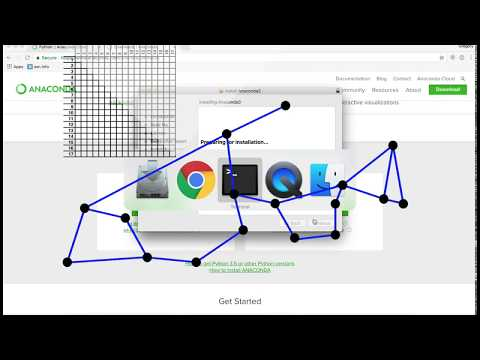

In [0]:
YouTubeVideo('uCXm6avugCo', width=1280, height=720)

In [0]:
import pandas as pd
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [0]:
def initialize_map(p_zero, N):
    """
    first thing is to create the map that you're trying to navigate.  I will do this randomly.
    This will be of the form of a adjacency matrix...
    In other words, an NxN matrix where each row and column correspond to an intersection on a map
    X_ij, then is equal to the amount of time that it takes to get from position i to position j
    could also be considered a distance measure... but whatever is easier to think about.
    practically, then we need a matrix that has numeric values in it... 
    there should be some paths that don't exist.  I will assign these a 0.  
    For instance, if you can't get directly from i to j, then X_ij = 0
    
    The initialization needs some tuning parameters.  One is the proportion of 0's in the final result
    """
    the_map = np.zeros((N,N))
    for i in range(0, N):
        for j in range(0, i):
            if random.random() > p_zero:
                the_map[i][j] = random.random()
                the_map[j][i] = the_map[i][j]
    return the_map

In [0]:
# Let's make a more complicated map that has at least 10 stops that have to be made and see what happens.
def initialize_complex_map(p_zero, N, groups):
    the_map = np.zeros((N,N))
    for i in range(0, N):
        for j in range(0, i):
            group_i = int(i/(N/groups))
            group_j = int(j/(N/groups))
            if random.random() > p_zero and abs(group_i - group_j) <= 1:
                the_map[i][j] = random.random()
                the_map[j][i] = the_map[i][j]
    ax = sns.heatmap(the_map)
    plt.show()
    return the_map

In [0]:
#this just creates a population of different routes of a fixed size. Pretty straightforward.
def create_starting_population(size, the_map):
    population = []
    for i in range(0,size):
        population.append(create_new_member(the_map))
    return population

In [0]:
def fitness(route, the_map):
    score = 0
    for i in range(1, len(route)):
        if (the_map[route[i-1]][route[i]] == 0) and i != len(the_map)-1:
            print("WARNING: INVALID ROUTE")
            print(route)
            print(the_map)
        score = score + the_map[route[i-1]][route[i]]
    return score

In [0]:
def crossover(a, b):
    """
    I initially made an error here by allowing routes to crossover at any point, which obviously won't work
    you have to insure that when the two routes cross over that the resulting routes produce a valid route
    which means that crossover points have to be at the same position value on the map
    """
    common_elements = set(a) & set(b)
    if len(common_elements) == 2:
        return (a, b)
    else:
        common_elements.remove(0)
        common_elements.remove(max(a)) 
        value = random.sample(common_elements, 1)        

    cut_a = np.random.choice(np.where(np.isin(a, value))[0])
    cut_b = np.random.choice(np.where(np.isin(b, value))[0])
    
    new_a1 = copy.deepcopy(a[0:cut_a])
    new_a2 = copy.deepcopy(b[cut_b:])
    
    new_b1 = copy.deepcopy(b[0:cut_b])
    new_b2 = copy.deepcopy(a[cut_a:])
    
    new_a = np.append(new_a1, new_a2)
    new_b = np.append(new_b1, new_b2)
       
    return (new_a, new_b)

In [0]:
def mutate(route, probability, the_map):
    new_route = copy.deepcopy(route)
    for i in range(1, len(new_route)):
        if random.random() < probability:
            go = True
            while go:
                possible_values = np.nonzero(the_map[new_route[i-1]])
                proposed_value = random.randint(0,len(possible_values[0])-1)
                route = np.append(new_route, possible_values[0][proposed_value])

                if new_route[i] == len(the_map)-1:
                    go = False
                else:
                    i += 1
    return new_route

In [0]:
def create_new_member(the_map):
    """
    here we are going to create a new route
    the new route can have any number of steps, so we'll select that randomly
    the structure of the route will be a vector of integers where each value is the next step in the route
    Everyone starts at 0, so the first value in the vector will indicate where to attempt to go next.
    That is, if v_i = 4, then that would correspond to X_0,4 in the map that was created at initialization
    
    N is the size of the map, so we need to make sure that 
    we don't generate any values that exceed the size of the map
    """
    N = len(the_map)
    route = np.zeros(1, dtype=int)
    go = True
    i = 1
    while go:    
        possible_values = np.nonzero(the_map[route[i-1]])
        proposed_value = random.randint(0,len(possible_values[0])-1)
        route = np.append(route, possible_values[0][proposed_value])
                
        if route[i] == N-1:
            go = False
        else:
            i += 1
    return route

In [0]:
def score_population(population, the_map):
    scores = []
    for i in range(0, len(population)):
        scores += [fitness(population[i], the_map)]    
    return scores

In [0]:
def pick_mate(scores):
    array = np.array(scores)
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    fitness = [len(ranks) - x for x in ranks]
    
    cum_scores = copy.deepcopy(fitness)
    for i in range(1,len(cum_scores)):
        cum_scores[i] = fitness[i] + cum_scores[i-1]
        
    probs = [x / cum_scores[-1] for x in cum_scores]
    rand = random.random()
    for i in range(0, len(probs)):
        if rand < probs[i]:
            return i

In [0]:
def plot_best(the_map, route, iteration_number):
    ax = sns.heatmap(the_map)

    x=[0.5] + [x + 0.5 for x in route[0:len(route)-1]] + [len(the_map) - 0.5]
    y=[0.5] + [x + 0.5 for x in route[1:len(route)]] + [len(the_map) - 0.5]
    
    plt.plot(x, y, marker = 'o', linewidth=4, markersize=12, linestyle = "-", color='white')
    # Create a image folder if there nothing
    if (os.path.isdir("/genetic_images") == False):
        os.mkdir("/genetic_images")
    plt.savefig('/genetic_images/new1000plot_%i.png' %(iteration_number), dpi=300)
    plt.show()

In [0]:
def main():
    # parameters
    sparseness_of_map = 0.95
    size_of_map = 100
    population_size = 30
    number_of_iterations = 2000
    number_of_couples = 9
    number_of_winners_to_keep = 2
    mutation_probability = 0.05
    number_of_groups = 1
    
    # initialize the map and save it
    the_map = initialize_complex_map(sparseness_of_map, size_of_map, number_of_groups)

    # create the starting population
    population = create_starting_population(population_size, the_map)

    last_distance = 1000000000
    # for a large number of iterations do:
        
    for i in range(0,number_of_iterations):
        new_population = []
        
        # evaluate the fitness of the current population
        scores = score_population(population, the_map)

        best = population[np.argmin(scores)]
        number_of_moves = len(best)
        distance = fitness(best, the_map)
        
        if distance != last_distance:
            print('Iteration %i: Best so far is %i steps for a distance of %f' % (i, number_of_moves, distance))
            plot_best(the_map, best, i)

        
        # allow members of the population to breed based on their relative score; 
            # i.e., if their score is higher they're more likely to breed
        for j in range(0, number_of_couples):  
            new_1, new_2 = crossover(population[pick_mate(scores)], population[pick_mate(scores)])
            new_population = new_population + [new_1, new_2]
  
        # mutate
        for j in range(0, len(new_population)):
            new_population[j] = np.copy(mutate(new_population[j], 0.05, the_map))
            
        # keep members of previous generation
        new_population += [population[np.argmin(scores)]]
        for j in range(1, number_of_winners_to_keep):
            keeper = pick_mate(scores)            
            new_population += [population[keeper]]
            
        # add new random members
        while len(new_population) < population_size:
            new_population += [create_new_member(the_map)]
            
        #replace the old population with a real copy
        population = copy.deepcopy(new_population)
                
        last_distance = distance
        
    # plot the results

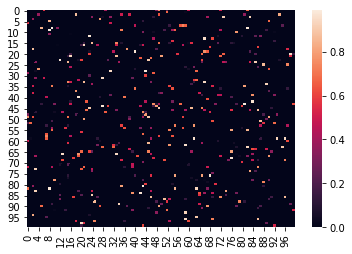

Iteration 0: Best so far is 7 steps for a distance of 3.748715


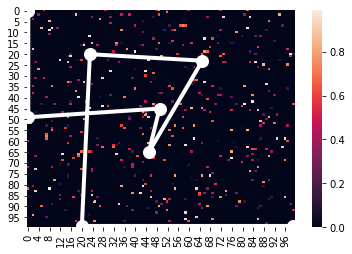

ValueError: ignored

In [0]:
main()

## Genetic machine learning
1. Setting environment
2. Utilize tools
3. Dataset
4. Create model 
5. Train model weight and bias with Genetic Algorithm
6. Conway game
7. Find the direct starting board of conway game of life using Genetic algorithm
8. Testing field

#### Setting environment
1. package install
2. package import
3. google drive mount
4. path configuration

In [0]:
!pip install pycuda

In [0]:
# pycuda - GPU
import pycuda.driver as cuda

In [0]:
# package import
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from copy import deepcopy
import os
import sys
import shutil
import math
import random
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm

In [0]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# path configuration
# TODO : Choose the path
model_path = '/content/drive/My Drive/42/reverse game of life/save'
kernel_path = '/content/drive/My Drive/42/reverse game of life/save'

### Utilize tools

- `visualize board` - visualize the conway board using seaborn heatmap
- `check valid game` - Check the conway game model works exactly same as original conway game

In [0]:
def visualize_board(board):
    plt.figure(figsize=(7, 7))
    sns.heatmap(board,
                square=True,
                linewidths=0.1,
                linecolor='gray',)
                # xticklabels=False,
                # yticklabels=False)

In [0]:
def check_valid_game(dataset, conway_game):
    total_len = len(dataset)
    correct = 0
    for i in tqdm(range(1, total_len + 1)):
        result = conway_game(dataset[i]["start"], dataset[i]["step"])
        if (result == dataset[i]["end"]).all():
            correct += 1
        sys.stdout.write("\rChecking the game is valid... {} / {}".format(correct, total_len))
        sys.stdout.flush()

### Dataset

Load the dataset from github and preprocess it to build a dataset to use in machine learning

    - train             [id / step / start board / end board]
    - test              [id / step / end board]
    - sample submission [id / start board] 

In [0]:
# Import dataset from github
train_pd = pd.read_csv("https://raw.githubusercontent.com/rquerino/Reverse-Game-of-Life/master/resources/train.csv")
test_pd = pd.read_csv("https://raw.githubusercontent.com/rquerino/Reverse-Game-of-Life/master/resources/test.csv")
sample_submission_pd = pd.read_csv("https://raw.githubusercontent.com/rquerino/Reverse-Game-of-Life/master/resources/sampleSubmission.csv")

In [0]:
def preprocess_dataset(pandas_dataset, type="train"):
    dataset = {}
    if (type == "train"):
        for data in tqdm(pandas_dataset.values):
            dataset[data[0]] = {"step": data[1],
                                "start": data[2:402].reshape(20, 20),
                                "end": data[402:802].reshape(20, 20)}
    elif (type == "test"):
        for data in tqdm(pandas_dataset.values):
            dataset[data[0]] = {"step": data[1],
                                "end": data[2:402].reshape(20, 20)}
    return dataset

In [0]:
print("Building train set")
train_set = preprocess_dataset(train_pd)
print("Building test set")
test_set = preprocess_dataset(test_pd, type="test")

Building train set



Building test set


### Create a model

end board -> model -> start board

    model (hyperparmeter - kernel_num, threshold)

**1 step represents one back step**
1. 1 evolve of conway game is 1 step
2. 1 step is has `few number of kernels` (3 x 3 matrix)
3. 1 kernel is consisted with (3 x 3) matrix 

#### Multi kernel model

1. class Kernel
2. class MultiKernels

In [0]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [0]:
class Kernel(object):
    """One kernel"""
    def __init__(self, kernel_size):
        """
        Prepare neccesary values

        IMAGE
        [1 2]
        [3 4]

        KERNEL SIZE 
        PAD
        pad_height = kernel_height - 1
        pad_height = kernel_width - 1

        Example - kernel size (2 x 2)
        [1 2 0]
        [3 4 0]
        [0 0 0]

        :param Tuple kernel_size: (h, w) kernel height and width 
        """
        self.kernel_size = kernel_size
        self.kernel_h = kernel_size[0]
        self.kernel_w = kernel_size[1]
        self.kernel = None

        # create the kernel
        self._create_kernel()
    
    def __call__(self, x):
        return self._forward(x)

    def __str__(self):
        return "kernel\nshape : {}\n{}\n".format(self.kernel.shape,
                                                 self.kernel)
 
    def __repr__(self):
        return "kernel({})".format(self.kernel_size)
    
    def _create_kernel(self):
        self._kernel_initialize()

    def _kernel_initialize(self):
        self.kernel = np.random.binomial(1, 0.5, size=(self.kernel_h,
                                                       self.kernel_w))
 
    def _pad(self, x, h, w):
        padded_x = np.zeros((h + self.kernel_h - 1,
                            w + self.kernel_w - 1))
        padded_x[:h,:w] = x
        return padded_x
    
    def _convolve(self, x, h, w):
        convolved_x = np.zeros((h, w))
        for i in range(h):
            for j in range(w):
                convolved_x[i][j] = (self.kernel * x[i:i+self.kernel_h,
                                                    j:j+self.kernel_w]).sum()
        return convolved_x       

    def _forward(self, x):
        h, w = x.shape
        x = self._pad(x, h, w)
        x = self._convolve(x, h, w)
        return x

In [0]:
import pickle

class MultiKernels(object):
    """Multi kernels"""
    def __init__(self, kernel_num, threshold, kernel_size_list=None):
        """
        Prepare neccesary values

        :param Tuple kernel_size_list: [(h, w), ... , (h, w)]
            -> list of kernel size tuples height and width
            -> if None fill the list to default value (3, 3)
        """
        self.kernel_num = kernel_num
        self._threshold = threshold
        self.kernel_size_list = kernel_size_list
        self.kernel_list = []

        # Initialize kernels size
        if (kernel_size_list):
            if (len(kernel_size_list) == kernel_num):
                self.kernel_size_list = kernel_size_list
            else:
                raise IndexError
        else:
            self.kernel_size_list = [(3, 3) for _ in range(self.kernel_num)]

        # Initialize kernels
        self._create_kernels()

    def __call__(self, x):
        return self._forward(x)

    def __str__(self):
        status = ""
        for i in range(1, self.kernel_num + 1):
            status += "kernel {}\n".format(i)
            status += str(self.kernel_list[i - 1])
            status += "\n"
        return status
    
    def __repr__(self):
        return "MultiKernels({}, {}, {})".format(self.kernel_num,
                                                self._threshold,
                                                self.kernel_size_list)
        
    def change_threshold(self, threshold):
        print("Threshold changed from {} ".format(self._threshold), end="")
        self._threshold = threshold
        print("to {}".format(self._threshold))
        

    def _create_kernels(self):
        for kernel_size in self.kernel_size_list:
            self.kernel_list.append(Kernel(kernel_size))
    
    def _create_board(self, x):
        x_shape = x.shape
        x = x.reshape(-1)
        x[np.where((x >= self._threshold).reshape(-1))] = 1
        x[np.where((x < self._threshold).reshape(-1))] = 0
        return x.reshape(x_shape)
    
    def _forward(self, x):
        result = np.zeros_like(x, dtype=float)
        for kernel in self.kernel_list:
            result += kernel(x)
        
        # Apply threshold
        return self._create_board(result)

    def save_model(self, path):
        model = [self.kernel_num,
                 self._threshold,
                 self.kernel_size_list]
        with open(path, 'wb') as f:
            pickle.dump(model, f)
        print("Model saved to {} successfully!".format(path))

    def save_kernels(self, path):
        kernels = []
        for kernel in self.kernel_list:
            kernels.append(kernel.kernel)
        with open(path, 'wb') as f:
            pickle.dump(kernels, f)
        print("Kernel saved to {} successfully!".format(path))

    def load_kernels(self, path):
        with open(path, 'rb') as f:
            kernels = pickle.load(f)
        for kernel_, kernel in zip(self.kernel_list, kernels):
            kernel_.kernel = kernel 
        print("Kernel loaded from {} successfully!".format(path))

#### model save and load

    Every model and weight data is saved by pickle

**Model**
1. save - MultiLayers.save_model(`path`)
2. load - load_model(`path`)

**matrix**
1. save - MultiLayers.save_matrixs(`path`)
2. load - MultiLayers.load_matrixs(`path`)

In [0]:
def load_model(path):
    with open(path, 'rb') as f:
        model = pickle.load(f)
    print("Model was loaded from {} successfully!".format(path))
    return MultiKernels(*model)

In [0]:
# Choose the name of model and weight
model_name = "model.pkl"
kernel_name = "kernel.pkl"

# Model save and load
model.save_model(os.path.join(model_path, model_name))
model = load_model(os.path.join(model_path, model_name))

# matrix save and load
model.save_kernels(os.path.join(kernel_path, kernel_name))
model.load_kernels(os.path.join(kernel_path, kernel_name))

##### Testing Model load and save

**Successfully passed!**

In [0]:
l = MultiLayers(2, 0.5)

In [0]:
l

MultiLayers(2, 0.5, [(20, 20), (20, 20)])

In [0]:
l.save_model(os.path.join(model_path, model_name))

Model saved to /content/drive/My Drive/42/reverse game of life/save/model.pkl successfully!


In [0]:
test = load_model(os.path.join(model_path, model_name))

Model was loaded from /content/drive/My Drive/42/reverse game of life/save/model.pkl successfully!


In [0]:
test

MultiLayers(2, 0.5, [(20, 20), (20, 20)])

##### Testing matrix load and save

**Successfully passed!**

In [0]:
l.save_matrixs(os.path.join(matrix_path, matrix_name))

Weight saved to /content/drive/My Drive/42/reverse game of life/save/weight.pkl successfully!


In [0]:
test.load_matrixs(os.path.join(matrix_path, matrix_name))

Weight loaded from /content/drive/My Drive/42/reverse game of life/save/weight.pkl successfully!


In [0]:
for i, (layer_1, layer_2) in enumerate(zip(l.layer_list, test.layer_list)):
    print("Comparing Layer {} ... ".format(i + 1), end="")
    if (layer_1.weight == layer_2.matrix).all():
        print("matrix is {} ".format("SAME"), end="")
    else:
        print("matrix is {} ".format("DIFFERENT"), end="")

Comparing Layer 1 ... weight is SAME bias is SAME
Comparing Layer 2 ... weight is SAME bias is SAME


### Train model with Genetic Algorithm

1. `Population` - specific number of multilayers
2. `Fitness` - Get the score for each multilayers using the 50,000 train set
     - This approach is not efficient but will consider later
3. `Selection` - Choose the model with highest score in specific fate
4. `Crossover` - Generate a child
5. `Mutation` - mutate the model matrix 

In [0]:
class Genetic(object):
    """Genetic Algorithm to train the model"""
    def __init__(self,
                 population_num,
                 kernel_num,
                 threshold=0.5,
                 kernel_size_list=None):
        """
        Choose the model 

        :param int population_num: Choose the number of population
        :param int kernel_num: Choose the size of kernel of one model
        :param float threshold: Choose the threshold that model will use to generate the board
        :param Tuple kernel_size_list: [(h, w), ... , (h, w)]
            -> list of kernel size tuples height and width
            -> if None fill the list to default value (3, 3)
        """
        self.population_num = population_num
        self.kernel_num = kernel_num
        self.threshold = threshold
        self.kernel_size_list = kernel_size_list
        self.model_info = [self.kernel_num,
                           self.threshold,
                           self.kernel_size_list]
        self.dataset_num = None

        # Create the Models to populate
        self.population()

    def save_model(self, path):
        """Saving the best model"""
        self.model_list[0].save_model(path)
    
    def save_kernel(self, path):
        """Saving the best kernel"""
        self.model_list[0].save_kernels(path)
    
    def load_model(self, path):
        with open(path, 'rb') as f:
            model = pickle.load(f)
        self.model_info = model
        self.kernel_num = self.model_info[0]
        self.threshold = self.model_info[1]
        self.kernel_size_list = self.model_info[2]
        self.population()
        print("Model was loaded from {} successfully!".format(path))
    
    def load_kernel(self, path):
        self.model_list[0].load_kernels(path)

    def __str__(self):
        status = ""
        for i, model in enumerate(self.model_list):
            status += "model {} ".format(i + 1)
            status += repr(model)
            status += "\n"
        return status
    
    def __repr__(self):
        return "Genetic({}, {}, {}, {})".format(self.population_num,
                                                *self.model_info)
        
    def __call__(self,
                 dataset,
                 batch_size=None,
                 generation_num=500,
                 survive_ratio=0.5,
                 mutation_probability=0.5,
                 mutation_area=0.2,
                 verbose=True,
                 print_every=10,
                 save_every=100,
                 model_path=None,
                 kernel_path=None):
        """
        :param dataset: Training dataset [id / step / start board / end board]
        :param batch_size: How much dataset will gonna use for each fitness score
        :param generation_num: How much generation we are going to run?
        :param survive_ratio: At the selection step how much model will survive?
        :param mutation_probability: Choose the probability to mutate model
        :param mutation area: When we mutate the model how many area we will gonna mutate?
        :param s
        """
        self.dataset = dataset
        self.dataset_len = len(self.dataset)
        if batch_size:
            self.batch_size = batch_size
        else:
            self.batch_size = self.dataset_len
        # Used to know how far it used dataset
        self.current_index = 0
        self.generation_num = generation_num
        self.survive_ratio = survive_ratio
        self.mutation_probability = mutation_probability
        self.mutation_area = mutation_area
        for generation in range(1, generation_num + 1):
            self.evolve()
            if verbose and (generation % print_every == 0):
                self.log(generation)
            if (generation % save_every == 0):
                if (model_path and kernel_path):
                    self.save_model(model_path + '_' + str(generation))
                    self.save_kernel(kernel_path + '_' + str(generation))
            
            # Update the current index to search next dataset in the next generation
            self.current_index = (self.current_index + self.batch_size) % self.dataset_len

    def best_model_score(self):
        """Using the best model predict the past"""
        # Use the best model
        model = self.model_list[0]

        # Show the model score
        print("Score will be tested in 50,000")
        model_score = self.model_score(model, mode='test')
        print("The model we are going to use has score : {}".format(model_score))

    def predict(self, predict_dataset, predict_dataset_index=None, visual=None):
        # Use the best model
        model = self.model_list[0]

        # Predict the result
        if (predict_dataset_index == None):
            print("Currently showing prediction for every dataset is not supported")
            print("Please choose specific index of dataset.")
            print("predict(dataset, predict_dataset_index=0)")
            raise NotImplementedError

        data = predict_dataset[predict_dataset_index]
        x = data['end']
        for _ in range(data['step']):
            x = model(x)
    
        if visual:
            # Show the result
            print("This is the end board")
            visualize_board(data['end'])
            print("This is the answer")
            visualize_board(data['start'])
            print("This is the prediction")
            visualize_board(x)
        else:
            return x

    def log(self, generation):
        """Print out the current situation of training"""
        self.score_list = []
        # Calculate the score
        for model in self.model_list:
            self.score_list.append(self.model_score(model, mode='train'))
        print("Generation [ {} / {} ]".format(generation, self.generation_num))
        print("Population {} - {}".format(self.population_num, self.score_list))
    
    def change_threshold(self, threshold):
        """Change the threshold of all the models"""
        for model in self.model_list:
            model.change_threshold(threshold)

    def change_population(self, population_num):
        """Change the population number and populate models again"""
        self.population_num = population_num
        self.population()
        print("Changed to {} population and repopulate model".format(self.population_num))
    
    def change_model(self, kernel_num, threshold=.5, kernel_size_list=None):
        """Change the model specification and populate models again"""
        self.kernel_num = kernel_num
        self.threshold = threshold
        self.kernel_size_list = kernel_size_list
        self.model_info = [self.kernel_num,
                           self.threshold,
                           self.kernel_size_list]
        self.population()
        print("Changed the model spec to {} and repopulate model".format(repr(self.model_list[0])))

    def population(self):
        self.model_list = []
        for _ in range(self.population_num):
            self.model_list.append(MultiKernels(*self.model_info))
        
        # Update the kernel size list to default value if it is not designated
        if self.kernel_size_list is None:
            self.kernel_size_list = self.model_list[0].kernel_size_list
            self.model_info = [self.kernel_num,
                               self.threshold,
                               self.kernel_size_list]
    
    def evolve(self):
        self.fitness()
        self.selection()
        self.crossover()
        self.mutation()

    def fitness(self):
        self.score_list = []
        # Calculate the score
        for model in self.model_list:
            self.score_list.append(self.model_score(model, mode='train'))

        # Sort the model list
        self.model_list = [self.model_list[index] for index in np.argsort(self.score_list)[::-1]]

    def model_score(self, model, mode='train'):
        total_score = 0
        total_count = 0
        if mode == 'train':
            for i in range(self.batch_size):
                index = (self.current_index + i) % self.dataset_len
                data = self.dataset[index + 1]
                x = data['end']
                for _ in range(data['step']):
                    x = model(x)
                total_score += self.score_method(x, data['start'])
                total_count += 1
        elif mode == 'test':
            for _, data in self.dataset.items():
                x = data['end']
                for _ in range(data['step']):
                    x = model(x)
                total_score += self.score_method(x, data['start'])
                total_count += 1
        else:
            raise NotImplementedError
        return round(total_score / total_count, 4)

    def score_method(self, output, target):
        return sum((output == target).reshape(-1))/400

    def selection(self):
        survive_num = round(self.population_num * self.survive_ratio)
        self.model_list = [self.model_list[index] for index in range(survive_num)]
    
    def crossover(self):
        # Reproduce childs to fill the population
        while (self.population_num != len(self.model_list)):
            parent = random.sample(self.model_list, 2)

            # Make child
            son, daugter = self.make_child(parent)
            self.model_list.append(son)
            if (self.population_num != len(self.model_list)):
                self.model_list.append(daugter)
    
    def make_child(self, parent):
        # parent
        dad = parent[0]
        mom = parent[1]

        # make child
        son = MultiKernels(*self.model_info)
        daughter = MultiKernels(*self.model_info)

        # Give the child a parent power
        for i, (dad_kernel, mom_kernel) in enumerate(zip(dad.kernel_list, mom.kernel_list)):
            # kernel reproduce
            reproduced = self.reproduce(dad_kernel.kernel, mom_kernel.kernel)
            son.kernel_list[i].kernel = reproduced[0]
            daughter.kernel_list[i].kernel = reproduced[1]

        return son, daughter      

    def reproduce(self, dad, mom):
        overlap = np.random.binomial(1, 0.5, size=dad.shape).astype('bool')
        son = deepcopy(dad)
        daugter = deepcopy(mom)
        son[overlap] = mom[overlap]
        daugter[overlap] = dad[overlap]
        return son, daugter

    def mutation(self):
        for i, model in enumerate(self.model_list):
            # Don't mutate the 1st, 2nd model
            if (i == 0 or i == 1):
                continue
            if random.random() < self.mutation_probability:
                self.mutate_model(model)

    def mutate_model(self, model):
        for kernel in model.kernel_list:
            k_shape = kernel.kernel.shape
            self.mutate_kernel(kernel, k_shape)
    
    def mutate_kernel(self, kernel, k_s):
        kernel_mutate_area = np.random.binomial(1, self.mutation_area, size=k_s)
        kernel.kernel += kernel_mutate_area
        kernel.kernel = np.where(kernel.kernel > 0,
                                kernel.kernel % 2,
                                kernel.kernel)


In [0]:
# Choose the name of model and kernel
model_name = "model01.pkl"
kernel_name = "kernel01.pkl"

model_g_path = os.path.join(model_path, model_name)
kernel_g_path = os.path.join(kernel_path, kernel_name)

In [0]:
# Create the Genetic Algorithm
g = Genetic(population_num=30,
            kernel_num=1,)
            # kernel_size_list=[(3, 3), (4, 4), (5, 5)])

In [0]:
small_train_set = {}
for i in range(1, 51):
    small_train_set[i] = train_set[i]

In [0]:
# Start training
g(dataset=small_train_set,
  batch_size=50,
  print_every=10,
  save_every=100,
  model_path=model_g_path,
  kernel_path=kernel_g_path,
  generation_num=10000)

Generation [ 10 / 10000 ]
Population 30 - [0.865, 0.8475, 0.7322, 0.6848, 0.7674, 0.7124, 0.7619, 0.7442, 0.7662, 0.5292, 0.5016, 0.4809, 0.5028, 0.5024, 0.5132, 0.4876, 0.5179, 0.5092, 0.5204, 0.5191, 0.5063, 0.5138, 0.5075, 0.5138, 0.4993, 0.4836, 0.4828, 0.527, 0.5055, 0.5098]


In [0]:
import cProfile
cProfile.run("""g(dataset=small_train_set,
  batch_size=50,
  print_every=10,
  save_every=1000,
  model_path=model_g_path,
  kernel_path=kernel_g_path,
  generation_num=1)""")

         5909196 function calls (5899596 primitive calls) in 10.754 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argsort)
     4800    0.003    0.000    0.018    0.000 <__array_function__ internals>:2(copyto)
     4800    0.004    0.000    0.015    0.000 <__array_function__ internals>:2(empty_like)
     9600    0.008    0.000    0.027    0.000 <__array_function__ internals>:2(where)
     4800    0.004    0.000    0.059    0.000 <__array_function__ internals>:2(zeros_like)
       16    0.000    0.000    0.000    0.000 <ipython-input-45-62a6f10e45ac>:3(__init__)
     4800    0.002    0.000    9.406    0.002 <ipython-input-45-62a6f10e45ac>:31(__call__)
       16    0.000    0.000    0.000    0.000 <ipython-input-45-62a6f10e45ac>:41(_create_kernel)
       16    0.000    0.000    0.000    0.000 <ipython-input-45-62a6f10e45ac>:44(_kernel_initialize)

In [0]:
g.best_model_score()

Score will be tested in 50,000


KeyboardInterrupt: ignored

This is the end board
This is the answer
This is the prediction


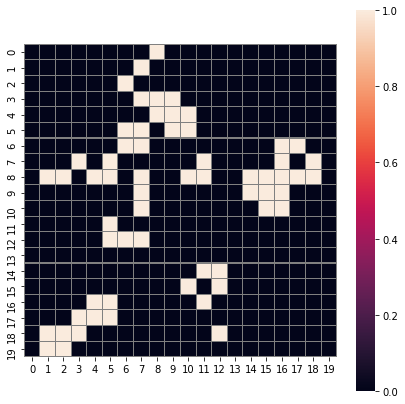

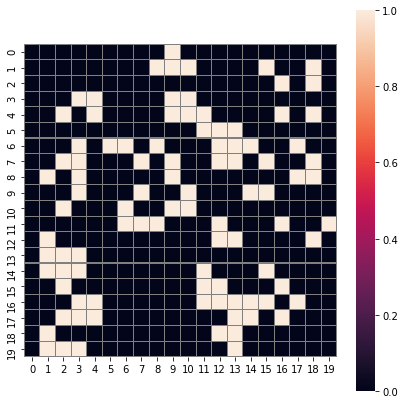

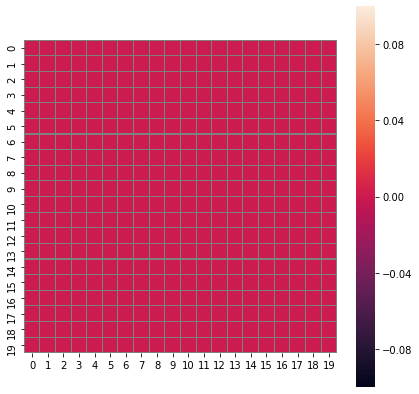

In [0]:
g.predict(train_set, 10, visual=True)

In [0]:
g.change_threshold(0.5)

Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5
Threshold changed from 1 to 0.5


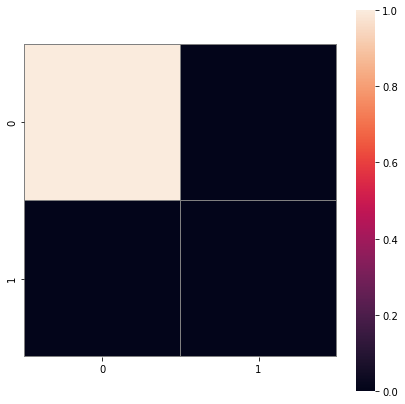

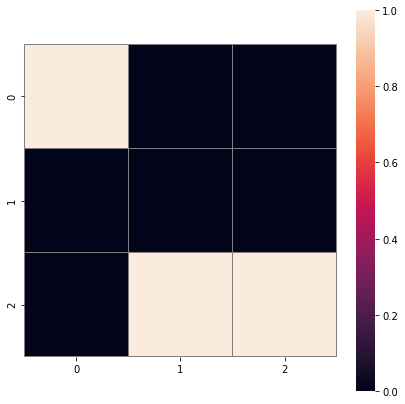

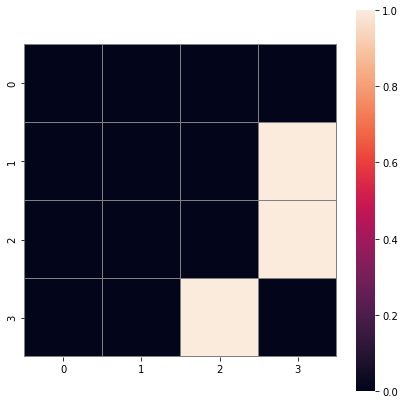

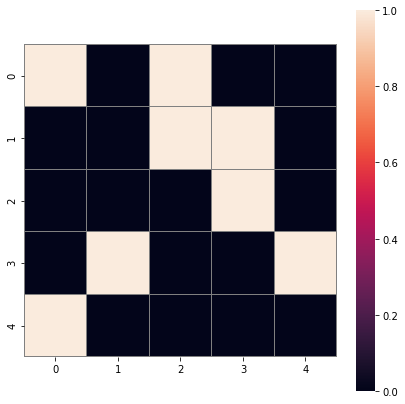

In [0]:
# Check the weight!
visualize_board(g.model_list[0].kernel_list[0].kernel)
visualize_board(g.model_list[0].kernel_list[1].kernel)
visualize_board(g.model_list[0].kernel_list[2].kernel)
visualize_board(g.model_list[0].kernel_list[3].kernel)

#### Save and load the model!

In [0]:
# Choose the name of model and weight
model_name = "model01.pkl"
kernel_name = "kernel01.pkl"

In [0]:
# Model and weight save
g.save_model(os.path.join(model_path, model_name))
g.save_kernel(os.path.join(kernel_path, kernel_name))

Model saved to /content/drive/My Drive/42/reverse game of life/save/model01.pkl successfully!
Kernel saved to /content/drive/My Drive/42/reverse game of life/save/kernel01.pkl successfully!


In [0]:
# Model and weight load
g.load_model(os.path.join(model_path, model_name))
g.load_kernel(os.path.join(kernel_path, kernel_name))

FileNotFoundError: ignored

### Conway game

Implementing conway game. This wont be used in case of building a neural network model. But will be used when we are directly finding the answer

![cellular automata](https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif)


In [0]:
class ConwayGameOfLife(object):
    """Implementation of Conway Game of Life"""
    def __init__(self, board_size):
        """
        Prepare neccesary values

        :param Tuple board_size: (h, w) board height and width
        :param list neighbor_coord: [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        :param int width: width
        :param int height: height
        """
        self.neighbor_coord = [(i, j) for i in range(-1, 2) for j in range(-1, 2) if i != 0 or j != 0]
        self.height = board_size[0]
        self.width = board_size[1]

    def __call__(self, board, step):
        return self._process_game(board, step)

    def _neighbor_count(self, board, h, w):
        total = 0
        for n_h, n_w in self.neighbor_coord:
            if (0 <= h + n_h < self.height
                and 0 <= w + n_w < self.width
                and board[h + n_h][w + n_w]):
                    total += 1
        return total
    
    def _evolve(self, board):
        new_board = deepcopy(board)
        for h in range(self.height):
            for w in range(self.width):
                live_num = self._neighbor_count(board, h, w)
                if board[h][w] and not (live_num == 2 or live_num ==3):
                    new_board[h][w] = 0
                elif board[h][w] == 0 and live_num == 3:
                    new_board[h][w] = 1
        return new_board

    def _process_game(self, board, step):
        for _ in range(step):
            board = self._evolve(board)
        return board


In [0]:
# Create the game
game = ConwayGameOfLife((20, 20))

In [0]:
# Check the game is valid compared to the original
check_valid_game(train_set, game)

Checking the game is valid... 50000 / 50000


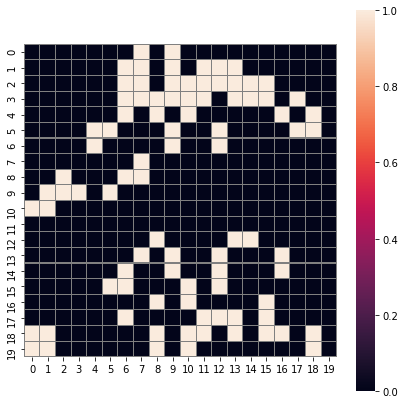

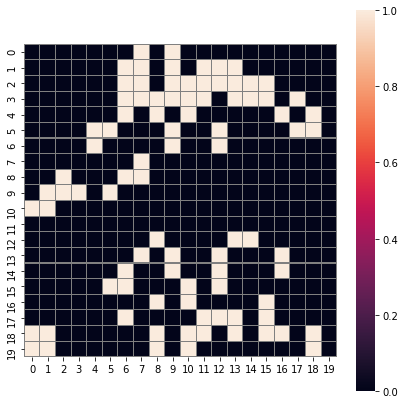

In [0]:
# Check the created game's output and original conway game's output
result = game(train_set[5]["start"], train_set[5]["step"])
visualize_board(result)
visualize_board(train_set[5]["end"])

### Find the direct starting board of conway game of life using Genetic algorithm

### Generate submission CSV

In [0]:
def generate_submission_file(model, dataset, path):
    result = []
    for i in range(1, len(dataset) + 1):
        output = model.predict(dataset, i).reshape(-1)
        id_array = np.array([i])
        result.append(np.append(id_array, output))

    # change it to numpy array
    result = np.array(result, dtype=int)

    # Generate index
    columns = ['start.{}'.format(i) for i in range(1, 401)]
    columns = ['id'] + columns

    # Generate submission file
    result = pd.DataFrame(result, columns=columns)
    result.to_csv(path, index=False)
    return (result)

In [0]:
model = g
dataset = test_set
submission_path = '/content/drive/My Drive/42/reverse game of life/reverse_game_of_life.csv'

In [0]:
result = generate_submission_file(model, dataset, submission_path)
result

,id,start.1,start.2,start.3,start.4,start.5,start.6,start.7,start.8,start.9,start.10,start.11,start.12,start.13,start.14,start.15,start.16,start.17,start.18,start.19,start.20,start.21,start.22,start.23,start.24,start.25,start.26,start.27,start.28,start.29,start.30,start.31,start.32,start.33,start.34,start.35,start.36,start.37,start.38,start.39,...,start.361,start.362,start.363,start.364,start.365,start.366,start.367,start.368,start.369,start.370,start.371,start.372,start.373,start.374,start.375,start.376,start.377,start.378,start.379,start.380,start.381,start.382,start.383,start.384,start.385,start.386,start.387,start.388,start.389,start.390,start.391,start.392,start.393,start.394,start.395,start.396,start.397,start.398,start.399,start.400
0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49996,49997,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49997,49998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49998,49999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Submit to kaggle

In [0]:
!ls -al /root
!rm -r ~/.kaggle
!mkdir ~/.kaggle

total 68
drwx------ 1 root root 4096 Jan  9 23:46 .
drwxr-xr-x 1 root root 4096 Jan  9 23:40 ..
-rw------- 1 root root 1056 Jan  9 23:46 .bash_history
-rw-r--r-- 1 root root 3106 Apr  9  2018 .bashrc
drwxr-xr-x 1 root root 4096 Jan  8 17:14 .cache
drwx------ 1 root root 4096 Jan  9 23:41 .config
drwxr-xr-x 3 root root 4096 Jan  8 16:41 .gsutil
drwxr-xr-x 1 root root 4096 Jan  8 17:11 .ipython
drwx------ 2 root root 4096 Jan  8 17:11 .jupyter
drwxr-xr-x 2 root root 4096 Jan  9 23:40 .keras
drwx------ 1 root root 4096 Jan  8 17:11 .local
drwxr-xr-x 3 root root 4096 Jan  8 17:11 .node-gyp
drwxr-xr-x 4 root root 4096 Jan  8 17:11 .npm
-rw-r--r-- 1 root root  148 Aug 17  2015 .profile
rm: cannot remove '/root/.kaggle': No such file or directory


In [0]:
!ls -al ~/.kaggle

total 12
drwxr-xr-x 2 root root 4096 Jan 10 05:06 .
drwx------ 1 root root 4096 Jan 10 05:06 ..


In [0]:
src = '/content/drive/My Drive/42/reverse game of life/kaggle.json'
dst = '/root/.kaggle'
shutil.copy(src, dst)

'/root/.kaggle/kaggle.json'

In [0]:
!kaggle competitions submit -c conway-s-reverse-game-of-life -f '/content/drive/My Drive/42/reverse game of life/reverse_game_of_life.csv' -m "10filter ver"

100% 38.4M/38.4M [00:12<00:00, 3.14MB/s]
Successfully submitted to Conway's Reverse Game of Life

In [0]:
test_pd = test_pd.drop(['delta'], axis=1)

In [0]:
mapping = {}
for i in range(1, 401):
    mapping['stop.{}'.format(i)] = 'start.{}'.format(i)

In [0]:
test_pd = test_pd.rename(columns=mapping)

In [0]:
submission_path = '/content/drive/My Drive/42/reverse game of life/reverse_game_of_life.csv'
test_pd.to_csv(submission_path, index=False)

In [0]:
test_pd

,id,start.1,start.2,start.3,start.4,start.5,start.6,start.7,start.8,start.9,start.10,start.11,start.12,start.13,start.14,start.15,start.16,start.17,start.18,start.19,start.20,start.21,start.22,start.23,start.24,start.25,start.26,start.27,start.28,start.29,start.30,start.31,start.32,start.33,start.34,start.35,start.36,start.37,start.38,start.39,...,start.361,start.362,start.363,start.364,start.365,start.366,start.367,start.368,start.369,start.370,start.371,start.372,start.373,start.374,start.375,start.376,start.377,start.378,start.379,start.380,start.381,start.382,start.383,start.384,start.385,start.386,start.387,start.388,start.389,start.390,start.391,start.392,start.393,start.394,start.395,start.396,start.397,start.398,start.399,start.400
0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,1,0,...,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
49996,49997,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
49997,49998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49998,49999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
sample_submission_pd

,id,start.1,start.2,start.3,start.4,start.5,start.6,start.7,start.8,start.9,start.10,start.11,start.12,start.13,start.14,start.15,start.16,start.17,start.18,start.19,start.20,start.21,start.22,start.23,start.24,start.25,start.26,start.27,start.28,start.29,start.30,start.31,start.32,start.33,start.34,start.35,start.36,start.37,start.38,start.39,...,start.361,start.362,start.363,start.364,start.365,start.366,start.367,start.368,start.369,start.370,start.371,start.372,start.373,start.374,start.375,start.376,start.377,start.378,start.379,start.380,start.381,start.382,start.383,start.384,start.385,start.386,start.387,start.388,start.389,start.390,start.391,start.392,start.393,start.394,start.395,start.396,start.397,start.398,start.399,start.400
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49996,49997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49997,49998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49998,49999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Testing field

In [0]:
import numpy as np
test = np.random.binomial(1, 0.5, (5, 5))
kernel = np.random.binomial(1, 0.5, (3, 3))

In [0]:
print(test)
print(kernel)

[[0 1 0 1 1]
 [0 1 1 0 0]
 [0 1 1 0 0]
 [0 0 0 1 0]
 [0 1 1 1 1]]
[[1 1 0]
 [0 1 0]
 [0 1 1]]


In [0]:
b = np.array([1, 2, 3])
print (w + b)

[[3.34207218 2.         3.1992841 ]
 [6.03511597 2.         3.23610978]
 [4.22490787 2.         3.6253408 ]]


##### Testing mask function

In [0]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[100, 200], [300, 400]])
mask = np.array([[False, True], [True, False]])

In [0]:
a[mask] = b[mask]

In [0]:
a

array([[  1, 200],
       [300,   4]])

In [0]:
b[mask]

array([200, 300])

In [0]:
c = deepcopy(a)

In [0]:
c

array([[  1, 200],
       [300,   4]])